## Workflows

The main benefits of Nipype are the workflows.

A workflow controls the setup and the execution of individual interfaces. 

Let's assume you want to run multiple interfaces in a specific order, where some have to 'wait' for others to finish while others can be executed in parallel. The workflow will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

A workflow therefore consists of multiple Nodes, each representing a specific Interface and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node.

#### **Preparation for Workflows**

In [2]:
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

# Short helper function to plot 3D NIfTI images

def plot_slice(fname):
    
    img = nb.load(fname)
    data = img.get_data()
    
    cut = int(data.shape[-1]/2) + 10
    # To cut in the middle of the brain
        # data.shape[-1]: the Z axis (height)
    
    plt.imshow(np.rot90(data[..., cut]), cmap = "gray")
    # np.rot90: rotate an array by 90 degrees in the plane
    
    plt.gca().set_axis_off()
    # plt.gca(): get the current Axes instance on the current figure
    #.set_axis_off(): turn off the x- and y- axes

## **Example 1 -`Command-line` execution**

- Skullstrip an image to obtain a mask
- Smooth the original image
- Mask the smoothed image

In [3]:
# This could all very well be doen with the following shell script: NOPE why???
%%bash
ANAT_NAME=sub-01_ses-test_T1w
ANAT=/data/ds000114/sub-01/ses-test/anat/${ANAT_NAME}
bet ${ANAT} /output/${ANAT_NAME}_brain -m -f 0.3
fslmaths ${ANAT} -s 2 /output/${ANAT_NAME}_smooth
fslmaths /output/${ANAT_NAME}_smooth -mas /output/${ANAT_NAME}_brain_mask /output/${ANAT_NAME}_smooth_mask

SyntaxError: invalid token (<ipython-input-3-1715dff0e5d7>, line 3)

FileNotFoundError: No such file or no access: '/output/sub-01_ses-test_T1w_smooth.nii.gz'

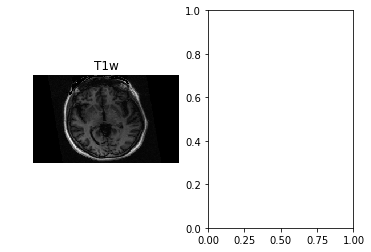

In [6]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1w", "T1w_smooth",
                         "T1w_brain_mask", "T1w_smooth_mask"]):
    f.add_subplot(1, 4, i + 1)
    if i == 0:
        plot_slice("/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_%s.nii.gz" % img)
    else:
        plot_slice("/output/sub-01_ses-test_%s.nii.gz" % img)
    plt.title(img)

## **Example 2 - `Interface` execution**

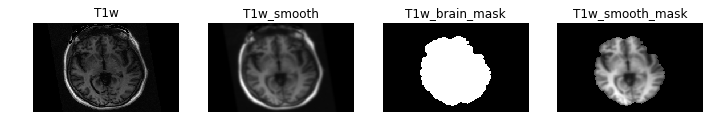

In [10]:
from nipype.interfaces import fsl

# Skullstrip process
skullstrip = fsl.BET(
    in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz",
    out_file = "/output/sub-01_T1w_brain.nii.gz",
    mask = True)
skullstrip.run()

# Smoothing process
smooth = fsl.IsotropicSmooth(
    in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz",
    out_file = "/output/sub-01_T1w_smooth.nii.gz", 
    fwhm = 4)
smooth.run()

# Masking process - ?
mask = fsl.ApplyMask(
    in_file = "/output/sub-01_T1w_smooth.nii.gz",
    out_file = "/output/sub-01_T1w_smooth_mask.nii.gz",
    mask_file = "/output/sub-01_T1w_brain_mask.nii.gz")
mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["T1w", "T1w_smooth",
                         "T1w_brain_mask", "T1w_smooth_mask"]):
    f.add_subplot(1, 4, i + 1)
    if i == 0:
        plot_slice("/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_%s.nii.gz" % img)
    else:
        plot_slice("/output/sub-01_%s.nii.gz" % img)
    plt.title(img)

#### **Can't we optimize it?**

The inputs for the mask routine in in_file and mask_file are actually the ouput of skullstrip and smooth. We therfore somehow want to connect them.

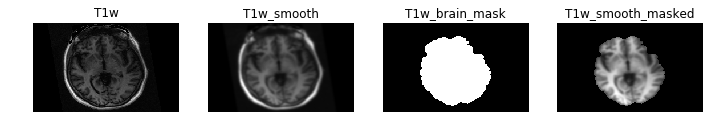

In [13]:
from nipype.interfaces import fsl

skullstrip =fsl.BET(
    in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz", mask = True)
bet_result = skullstrip.run()

smooth = fsl.IsotropicSmooth(
    in_file = "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz", fwhm = 4)
smooth_result = smooth.run()

mask = fsl.ApplyMask(
    in_file = smooth_result.outputs.out_file,
    mask_file = bet_result.outputs.mask_file)
mask_result = mask.run()

f = plt.figure(figsize=(12, 4))
for i, img in enumerate([skullstrip.inputs.in_file, smooth_result.outputs.out_file,
                         bet_result.outputs.mask_file, mask_result.outputs.out_file]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)
    plt.title(img.split('/')[-1].split('.')[0].split('test_')[-1])

This is comewhat more concise than the example above, but it's still a procedural script. And the dependency relationship between the stages of processing is not particularly obvious. To address these issues, Nipype offers **Workflows**.

## **Example 3 - `Workflow` execution**

Each stage of processing is a node in this graph, and some nodes are unidirectionally dependent on others. In this case, there is one input file and several output files, but there are no cycles -- there's a clear line of directionality to the processing. What the Node and Workflow classes do is to make these relationships more explicit.

The basic architecture is that **the Node provides a light wrapper around an Interace. It exposes the inputs and outputs of the Interface as its own, but it adds some functionality that allows you to connect Nodes into a Workflow.**

In [15]:
from nipype import Node, Workflow
from nipype.interfaces import fsl

# Pass filenames to Nodes as absolute paths (later it's important)
from os.path import abspath
in_file = abspath("/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz")

skullstrip = Node(fsl.BET(in_file = in_file, mask = True), name = "skullstrip")

smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm = 4), name = "smooth")

mask = Node(fsl.ApplyMask(), name = "mask")

This looks mostly similar to what we did above, but we've left out the two crucial inputs to the ApplyMask step. We'll set those up by defining a Workflow object and then making connections among the Nodes.

In [16]:
# 1. Initiating a Workflow

wf = Workflow(name = "smoothflow", base_dir = "/output/working_dir")

In [17]:
# 2. Connecting

wf.connect(skullstrip, "mask_file", mask, "mask_file")

wf.connect(
    [
        (smooth, mask, 
         [
             ("out_file", "in_file")
         ]
        )
    ]
)

190128-02:52:19,261 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/smoothflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


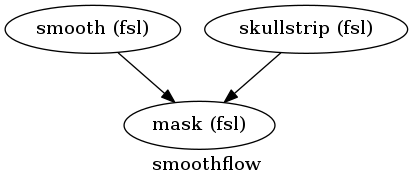

In [19]:
# 3. Exploring the workflow visaully

wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename = "/output/working_dir/smoothflow/workflow_graph.png")

190128-02:53:10,646 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/smoothflow/graph.png (graph2use=flat, simple_form=True).


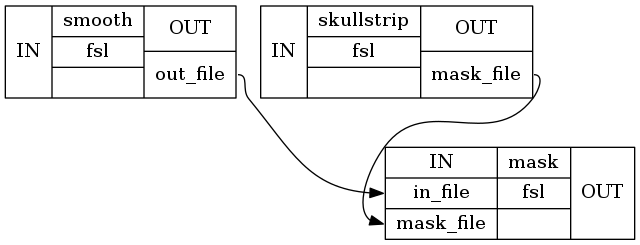

In [20]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="/output/working_dir/smoothflow/graph_detailed.png")

In [22]:
# 4. Executing

wf.base_dir = "/output/working_dir"
    # This specification is very important because otherwise all the outputs would be saved somewhere in the temporary files.
    # This is why we needed to use absolute paths above...
    # Unlike interfaces, which by default spit out results to the local directly, the Workflow engine executes things off in its own directory hierarchy.

wf.run()

190128-02:57:13,292 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
190128-02:57:13,319 nipype.workflow INFO:
	 Running serially.
190128-02:57:13,321 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/output/working_dir/smoothflow/smooth".
190128-02:57:13,333 nipype.workflow INFO:
	 [Node] Cached "smoothflow.smooth" - collecting precomputed outputs
190128-02:57:13,334 nipype.workflow INFO:
	 [Node] "smoothflow.smooth" found cached.
190128-02:57:13,336 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/output/working_dir/smoothflow/skullstrip".
190128-02:57:13,351 nipype.workflow INFO:
	 [Node] Cached "smoothflow.skullstrip" - collecting precomputed outputs
190128-02:57:13,352 nipype.workflow INFO:
	 [Node] "smoothflow.skullstrip" found cached.
190128-02:57:13,353 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.mask" in "/output/working_dir/smoothflow/mask".
190128-02:57:13,375 nipype.workflo

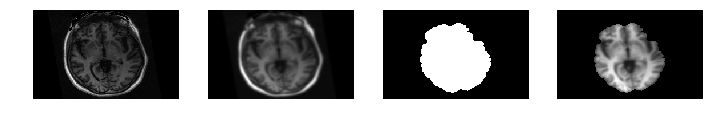

In [23]:
f = plt.figure(figsize=(12, 4))
for i, img in enumerate(["/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz",
                         "/output/working_dir/smoothflow/smooth/sub-01_ses-test_T1w_smooth.nii.gz",
                         "/output/working_dir/smoothflow/skullstrip/sub-01_ses-test_T1w_brain_mask.nii.gz",
                         "/output/working_dir/smoothflow/mask/sub-01_ses-test_T1w_smooth_masked.nii.gz"]):
    f.add_subplot(1, 4, i + 1)
    plot_slice(img)
    
    #이 코딩은 또 뭐지..

In [24]:
!tree /output/working_dir/smoothflow/ -I '*js|*json|*html|*pklz|_report'

/output/working_dir/smoothflow/
├── graph_detailed.dot
├── graph_detailed.png
├── graph.dot
├── graph.png
├── mask
│   ├── command.txt
│   └── sub-01_ses-test_T1w_smooth_masked.nii.gz
├── skullstrip
│   ├── command.txt
│   └── sub-01_ses-test_T1w_brain_mask.nii.gz
├── smooth
│   ├── command.txt
│   └── sub-01_ses-test_T1w_smooth.nii.gz
├── workflow_graph.dot
└── workflow_graph.png

3 directories, 12 files


### **Things to keep in mind**

In fact, nipype workflows are just (directed acyclic) Graphs. Thus, running a workflow object will return a graph object.

Workflows don't have inputs and outputs-you can just access them through the Node decoration.

From the resulting obejct of the workflow execution, you don't generally have access to the value of the outputs of the interfaces!

## **Nested Workflows**

Nested Workflows: a sub-workflow takes the place of a Node in a given script. (workflow inside a node)


190128-03:11:30,367 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/nipype_tutorial/Practices/Basics/susan_workflow.png (graph2use=hierarchical, simple_form=True).


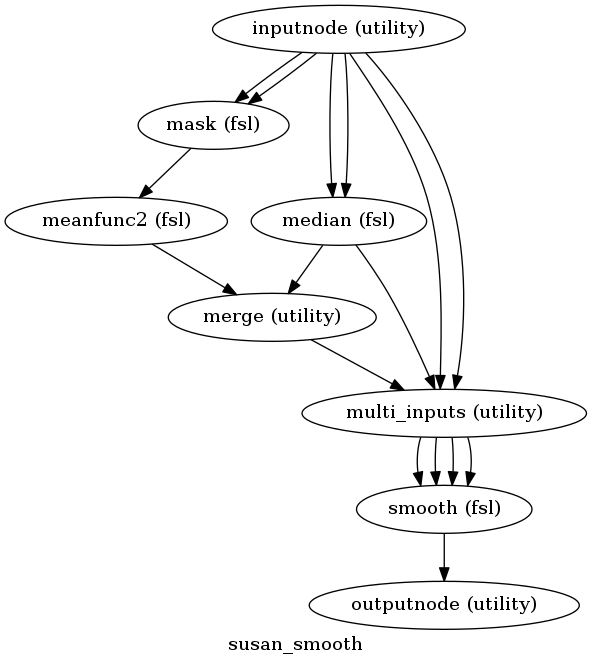

In [27]:
from nipype.workflows.fmri.fsl import create_susan_smooth

# This function willl return a pre-written Workflow object.
susan = create_susan_smooth(separate_masks = False)

susan.write_graph("susan_workflow.dot")
from IPython.display import Image
Image(filename = "susan_workflow.png")

We see that the workflow has an inputnode and an outputnode. While not strictly necessary, this is standard practice for workflows. Let's take a look at what those inputs and outputs are. Like Nodes, Workflows have inputs and outputs attributes that take a second sub-attribute(?) coressponding to the specific node we want to make connections to.

In [29]:
print("Inputs:\n", susan.inputs.inputnode)
print("Outputs:\n", susan.outputs.outputnode)

Inputs:
 
fwhm = <undefined>
in_files = <undefined>
mask_file = <undefined>

Outputs:
 
smoothed_files = None



In [30]:
susan.inputs


inputnode = 
fwhm = <undefined>
in_files = <undefined>
mask_file = <undefined>

mask = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
mask_file = <undefined>
op_string = -mas
out_data_type = <undefined>
out_file = <undefined>
output_type = NIFTI_GZ
suffix = _mask

meanfunc2 = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
in_file2 = <undefined>
mask_file = <undefined>
op_string = -Tmean
out_data_type = <undefined>
out_file = <undefined>
output_type = NIFTI_GZ
suffix = _mean

median = 
args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
op_string = -k %s -p 50
output_type = NIFTI_GZ
split_4d = <undefined>

merge = 
axis = hstack
no_flatten = False
ravel_inputs = False

multi_inputs = 
function_str = def cartesian_product(fwhms, in_files, usans, btthresh):
    from nipype.utils.filemanip import ensure_list
    # ensure all inputs are lists
    in_files = ensure_list(in_files)
    fwhms = [fwhms] if isinstance(fwhms, (int, float)) else fwhms
    # create 

The susan workflow actually expects to receive and output a list of files (it's intended to be executed on each of several runs of fMRI data). We'll cover exactly how that works in later tutorials, but for the moment we need to add an additional `Function` node to deal with the fact that **``susan`` is outputting a list.** We can use a simple ``lambda`` function to do this: 

In [31]:
from nipype import Function
extract_func = lambda list_out : list_out[0]
list_extract = Node(Function(input_names = ["list_out"],
                             output_names = ["out_file"],
                             function = extract_func),
                   name = "list_extract")

Now let's create a new workflow `susanflow` that contains the `susan` workflow as a sub-node. To be sure, let's also recreate the `skullstrip` and the `mask` node from the examples above.

In [32]:
wf2 = Workflow(name = "susanflow", base_dir = "/output/working_dir")

skullstrip2 = Node(fsl.BET(in_file = in_file, mask = True), name = "skullstrip")
mask2 = Node(fsl.ApplyMask(), name = "mask")

wf2.connect([(skullstrip2, mask2, [("mask_file", "mask_file")]),
             (skullstrip2, susan, [("mask_file", "inputnode.mask_file")]),
             (susan, list_extract, [("outputnode.smoothed_files",
                                     "list_out")]),
             (list_extract, mask2, [("out_file", "in_file")])
             ])

# Specify the remaining input variables for the susan workflow
susan.inputs.inputnode.in_files = abspath(
    "/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz")
susan.inputs.inputnode.fwhm = 4

190128-04:13:41,594 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/full_susanflow.png (graph2use=colored, simple_form=True).


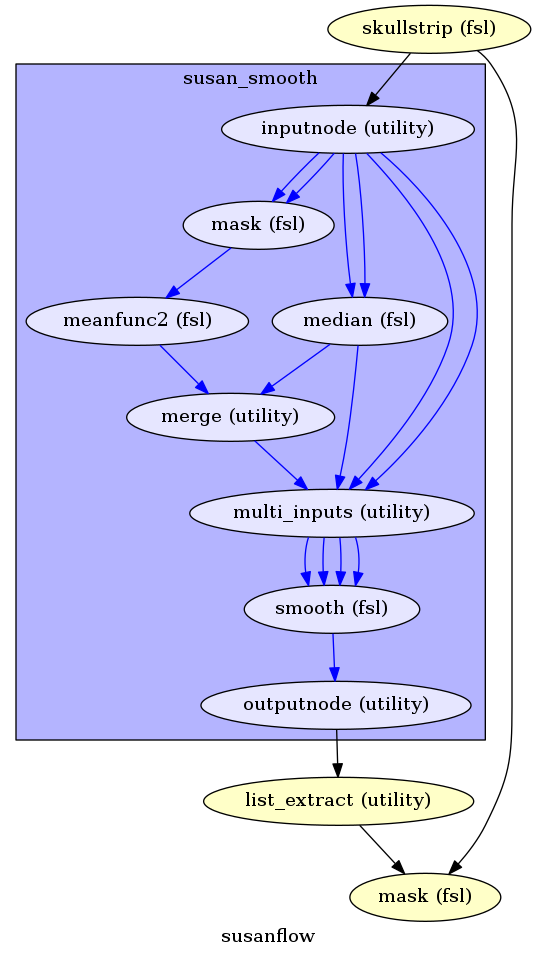

In [33]:
wf2.write_graph(dotfilename='/output/working_dir/full_susanflow.dot', graph2use='colored')
from IPython.display import Image
Image(filename="/output/working_dir/full_susanflow.png")

190128-04:14:44,194 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/full_susanflow_toplevel.png (graph2use=orig, simple_form=True).


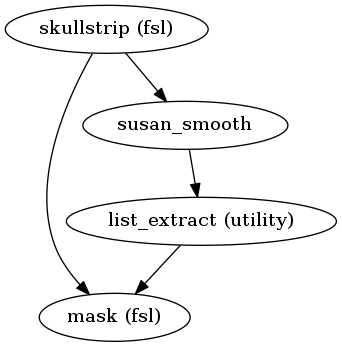

In [34]:
# To get a higher-level summary of the processing steps

wf2.write_graph(dotfilename='/output/working_dir/full_susanflow_toplevel.dot', graph2use='orig')
from IPython.display import Image
Image(filename="/output/working_dir/full_susanflow_toplevel.png")

In [35]:
wf2.run()

190128-04:14:52,299 nipype.workflow INFO:
	 Workflow susanflow settings: ['check', 'execution', 'logging', 'monitoring']
190128-04:14:52,336 nipype.workflow INFO:
	 Running serially.
190128-04:14:52,339 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.skullstrip" in "/output/working_dir/susanflow/skullstrip".
190128-04:14:52,368 nipype.workflow INFO:
	 [Node] Running "skullstrip" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /output/working_dir/susanflow/skullstrip/sub-01_ses-test_T1w_brain.nii.gz -m
190128-04:14:56,534 nipype.workflow INFO:
	 [Node] Finished "susanflow.skullstrip".
190128-04:14:56,535 nipype.workflow INFO:
	 [Node] Setting-up "susanflow.susan_smooth.mask" in "/output/working_dir/susanflow/susan_smooth/mask".
190128-04:14:56,571 nipype.workflow INFO:
	 [Node] Setting-up "_mask0" in "/output/working_dir/susanflow/susan_smooth/mask/mapflow/_mask0".
190128-04:14:56,597

In [36]:
wf.inputs.smooth.fwhm = 1
wf.run()

190128-04:15:48,360 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
190128-04:15:48,382 nipype.workflow INFO:
	 Running serially.
190128-04:15:48,383 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/output/working_dir/smoothflow/smooth".
190128-04:15:48,394 nipype.workflow INFO:
	 [Node] Outdated cache found for "smoothflow.smooth".
190128-04:15:48,433 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz -s 0.42466 /output/working_dir/smoothflow/smooth/sub-01_ses-test_T1w_smooth.nii.gz
190128-04:15:51,728 nipype.workflow INFO:
	 [Node] Finished "smoothflow.smooth".
190128-04:15:51,729 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/output/working_dir/smoothflow/skullstrip".
190128-04:15:51,739 nipype.workflow INFO:
	 [Node] Cached "smoothflo

## **Exercise 1**

Create a workflow that connects three nodes for:

* skipping the first 3 dummy scans using fsl.ExtractROI
* applying motion correction using fsl.MCFLIRT (register to the mean volume, use NIfTI as output type)
* correcting for slice wise acquisition using fsl.SliceTimer (assumed that slices were acquired with interleaved order adn time repetition was 2.5, use NIfTI as output type)

In [37]:
from nipype import Workflow, Node

from nipype.interfaces.fsl import ExtractROI, MCFLIRT, SliceTimer

In [38]:
ExtractROI.help()

Wraps command **fslroi**

Uses FSL Fslroi command to extract region of interest (ROI)
from an image.

You can a) take a 3D ROI from a 3D data set (or if it is 4D, the
same ROI is taken from each time point and a new 4D data set is
created), b) extract just some time points from a 4D data set, or
c) control time and space limits to the ROI.  Note that the
arguments are minimum index and size (not maximum index).  So to
extract voxels 10 to 12 inclusive you would specify 10 and 3 (not
10 and 12).


Examples
--------

>>> from nipype.interfaces.fsl import ExtractROI
>>> from nipype.testing import anatfile
>>> fslroi = ExtractROI(in_file=anatfile, roi_file='bar.nii', t_min=0,
...                     t_size=1)
>>> fslroi.cmdline == 'fslroi %s bar.nii 0 1' % anatfile
True

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file
		flag: %s, position: 0

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	crop_list: (a list of items which are 

1. Define all nodes

In [42]:
extract = Node(ExtractROI(t_min = 4, t_size = -1, output_type = 'NIFTI'),
               name = "extract") #t_size?

mcflirt = Node(MCFLIRT(mean_vol = True,
                       output_type = 'NIFTI'),
               name = "mcflirt")

slicetimer = Node(SliceTimer(interleaved = True,
                             output_type = 'NIFTI',
                             time_repetition = 2.5),
                  name = "slicetimer")

2. Create a workflow

In [45]:
wf_ex1 = Workflow(name = "exercise1", base_dir = "/output/working_dir")

wf_ex1.connect([(extract, mcflirt, [('roi_file', 'in_file')]),
                  (mcflirt, slicetimer, [('out_file', 'in_file')])])
# Provide an input file for the first extract node
extract.inputs.in_file = "/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz"

3. Visualize and run the workflow

190128-04:37:34,925 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/exercise1/workflow_graph.png (graph2use=hierarchical, simple_form=True).


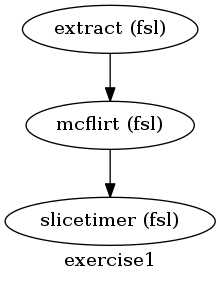

In [46]:
wf_ex1.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename = "/output/working_dir/exercise1/workflow_graph.png")

190128-04:38:30,47 nipype.workflow INFO:
	 Generated workflow graph: /output/working_dir/exercise1/graph.png (graph2use=flat, simple_form=True).


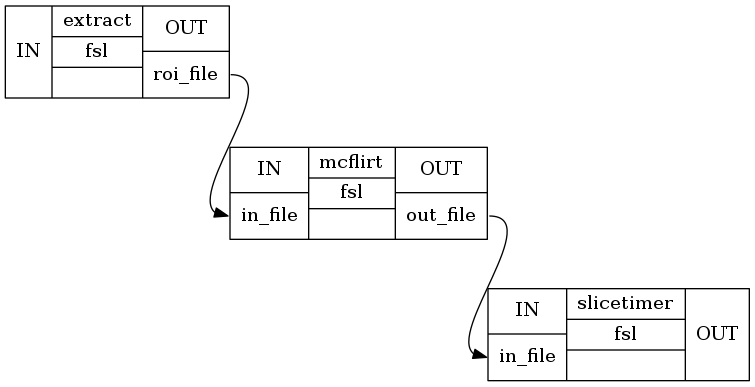

In [48]:
wf_ex1.write_graph(graph2use = 'flat')
from IPython.display import Image
Image(filename = "/output/working_dir/exercise1/graph_detailed.png")

In [49]:
wf_ex1.run()

190128-04:38:45,75 nipype.workflow INFO:
	 Workflow exercise1 settings: ['check', 'execution', 'logging', 'monitoring']
190128-04:38:45,104 nipype.workflow INFO:
	 Running serially.
190128-04:38:45,106 nipype.workflow INFO:
	 [Node] Setting-up "exercise1.extract" in "/output/working_dir/exercise1/extract".
190128-04:38:45,138 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz /output/working_dir/exercise1/extract/sub-01_ses-test_task-fingerfootlips_bold_roi.nii 4 -1
190128-04:38:46,50 nipype.workflow INFO:
	 [Node] Finished "exercise1.extract".
190128-04:38:46,51 nipype.workflow INFO:
	 [Node] Setting-up "exercise1.mcflirt" in "/output/working_dir/exercise1/mcflirt".
190128-04:38:46,78 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
m

In [50]:
! ls -lh /output/working_dir/exercise1

total 400K
-rw-r--r-- 1 neuro users 319K Jan 28 04:38 d3.js
drwxr-xr-x 9 neuro users  288 Jan 28 04:38 extract
-rw-r--r-- 1 neuro users 1006 Jan 28 04:38 graph1.json
-rw-r--r-- 1 neuro users  435 Jan 28 04:38 graph_detailed.dot
-rw-r--r-- 1 neuro users  18K Jan 28 04:38 graph_detailed.png
-rw-r--r-- 1 neuro users  149 Jan 28 04:38 graph.dot
-rw-r--r-- 1 neuro users  380 Jan 28 04:38 graph.json
-rw-r--r-- 1 neuro users  15K Jan 28 04:38 graph.png
-rw-r--r-- 1 neuro users 6.6K Jan 28 04:38 index.html
drwxr-xr-x 9 neuro users  288 Jan 28 04:39 mcflirt
drwxr-xr-x 9 neuro users  288 Jan 28 04:39 slicetimer
-rw-r--r-- 1 neuro users  266 Jan 28 04:37 workflow_graph.dot
-rw-r--r-- 1 neuro users  14K Jan 28 04:37 workflow_graph.png
